# Data Engineering

In [ ]:
import pandas as pd

df = pd.read_csv('btc_features_output.csv')
df.head()

# Show the first 5 rows
print(df.head())

# Show the column names
print(df.columns.tolist())

     start_time  cg_longShortRatio  cg_longAccount    cg_buy  cq_is_shutdown  \
0  1.681603e+12           1.370370       -0.772040 -0.375654             0.0   
1  1.681607e+12          -0.666667       -0.756042  0.521808             0.0   
2  1.681610e+12           0.851852       -0.764389 -0.416774             0.0   
3  1.681614e+12          -0.259259       -0.764389 -0.536372             0.0   
4  1.681618e+12           0.666667       -0.772735 -0.319397             0.0   

   cq_netflow_total  cq_transactions_count_inflow  \
0          0.258809                     -0.205667   
1         -0.134542                     -0.403108   
2          0.186270                     -0.154479   
3         -0.339551                     -0.496344   
4          0.519098                     -0.092322   

   cq_transactions_count_outflow  cq_reserve  cq_reserve_usd  ...  \
0                       0.863636    0.586101       -0.008144  ...   
1                      -0.363636    0.581715       -0.016572  

## Feature Selection

### Correlation Matrix Analysis

If two features have a very high correlation (say, Pearson’s r > 0.9), it means they carry very similar information.
Keeping both:

- Adds redundancy
- Can cause multicollinearity problems (in models like linear regression, but less of an issue for HMM)
- Can unnecessarily increase model complexity and overfitting risk


<ipython-input-14-2ef59acc49c9>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_pairs['OrderedPair'] = corr_pairs.apply(lambda row: tuple(sorted([row['Feature1'], row['Feature2']])), axis=1)


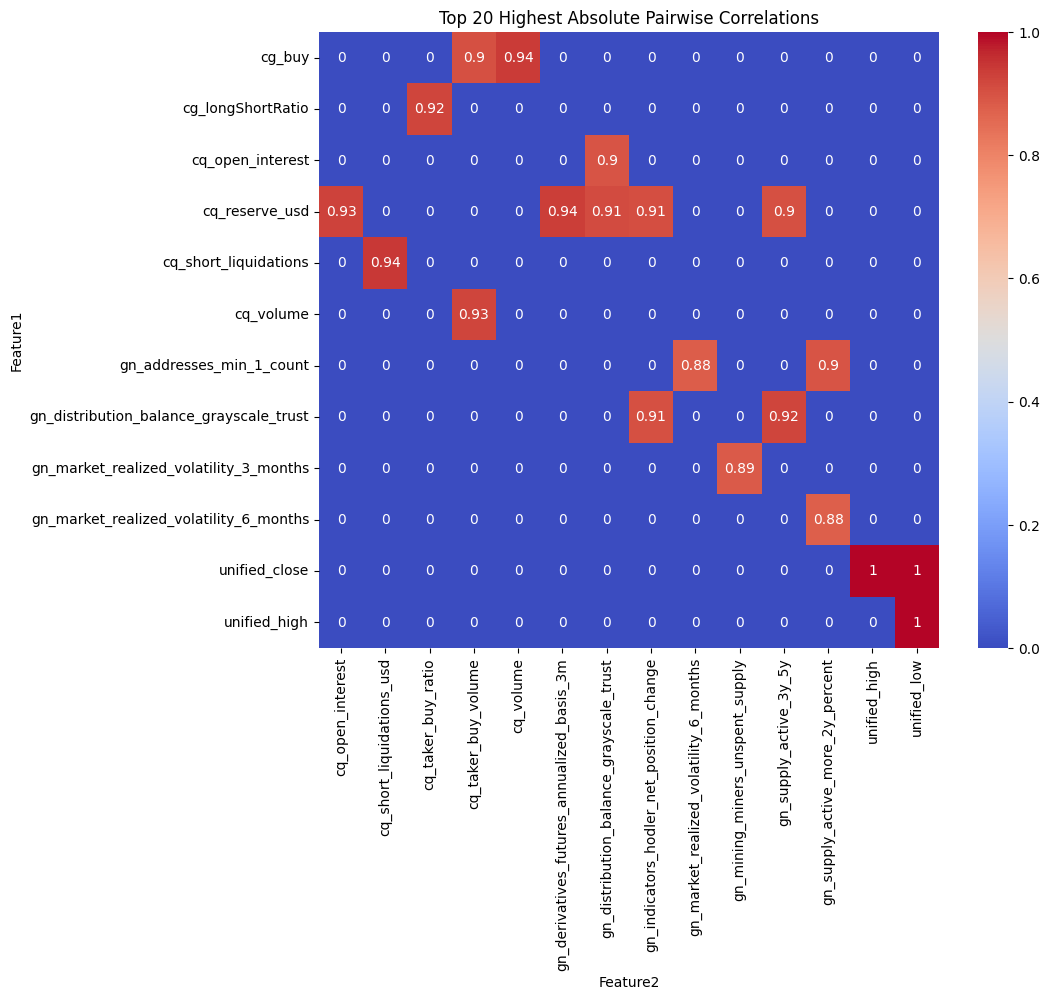

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('btc_features_output.csv')

# Select only numeric columns from the DataFrame
numeric_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix for numeric columns only
corr_matrix = numeric_df.corr()

# Unstack the correlation matrix to get pairwise correlations and reset index
corr_pairs = corr_matrix.abs().unstack().reset_index()
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

# Remove self-correlations (i.e., where Feature1 == Feature2) and duplicate pairs (A-B and B-A)
corr_pairs = corr_pairs[corr_pairs['Feature1'] != corr_pairs['Feature2']]
corr_pairs['OrderedPair'] = corr_pairs.apply(lambda row: tuple(sorted([row['Feature1'], row['Feature2']])), axis=1)
corr_pairs = corr_pairs.drop_duplicates(subset='OrderedPair').drop(columns='OrderedPair')

# Get top 20 highest absolute correlations
top_20_pairs = corr_pairs.sort_values(by='Correlation', ascending=False).head(20)

# Create a pivot table for the top 20 correlations
top_20_matrix = top_20_pairs.pivot(index='Feature1', columns='Feature2', values='Correlation').fillna(0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(top_20_matrix, annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1)
plt.title("Top 20 Highest Absolute Pairwise Correlations")
plt.show()


### Feature importance using XGBoast
XGBoost is a tree-based model, making it more suitable for capturing complex, non-linear relationships in the data, which is common in financial and crypto datasets. It provides clear and interpretable feature importance metrics, helping to identify key variables for your alpha strategy.


Assumption 1: Assume that features directly related to future price movements (1 day forward) are key to predicting market behavior.


      unified_close    return  target  future_target
8321       0.153686  0.005254       0            0.0
8322       0.132059 -0.140725       0            1.0
8323       0.160022  0.211751       1            0.0
8324       0.165356  0.033333       0            0.0
8325       0.181298  0.096411       0            0.0
8326       0.197377  0.088684       0           -1.0
8327       0.103933 -0.473429      -1           -1.0
8328       0.072664 -0.300859      -1            1.0
8329       0.208396  1.867957       1            0.0
8330       0.206025 -0.011381       0            0.0
8331       0.209316  0.015975       0            0.0
8332       0.249962  0.194188       0            0.0
8333       0.235536 -0.057713       0            0.0
8334       0.226938 -0.036504       0            1.0
8335       0.309267  0.362782       1            0.0
8336       0.323324  0.045450       0            0.0
8337       0.307780 -0.048074       0            0.0
8338       0.276394 -0.101975       0         

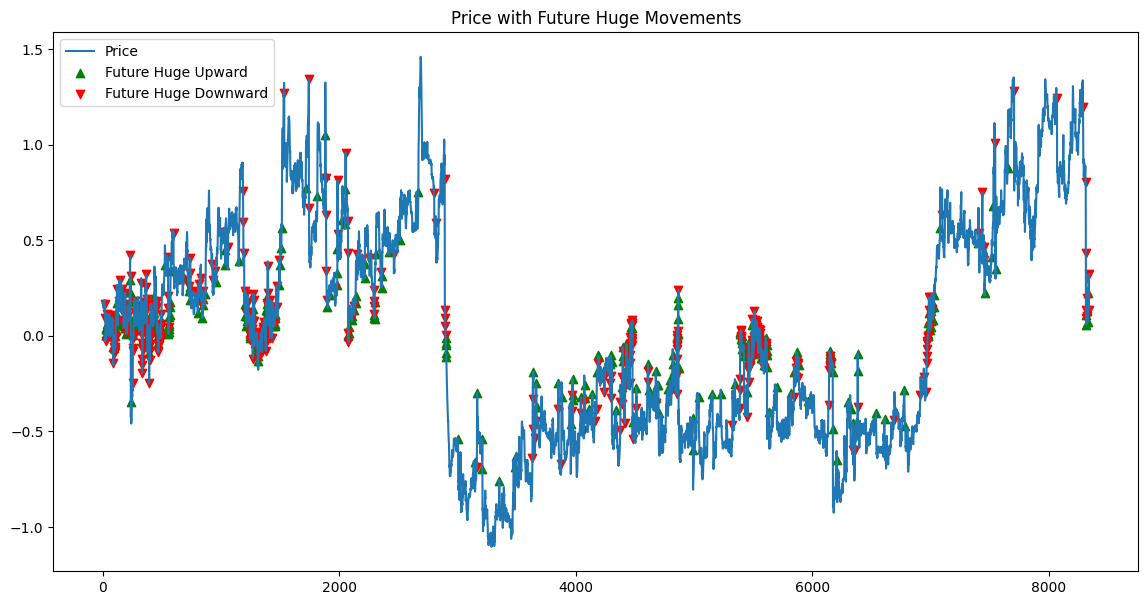

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your processed DataFrame and 'target' is the column you want to predict
X = df.drop(columns=['date'])  # Features, excluding 'date' for now

# Calculate percentage change for price movements
df['return'] = df['unified_close'].pct_change()
threshold = 0.20  # Define the threshold for huge price movements

# Create target variable for significant price movement
df['target'] = 0  # Default: no significant movement
df.loc[df['return'] >= threshold, 'target'] = 1  # Huge upward movement
df.loc[df['return'] <= -threshold, 'target'] = -1  # Huge downward movement

# Shift the target variable to predict future price movements
df['future_target'] = df['target'].shift(-1)

# Drop rows with NaN values due to shifting
df = df.dropna(subset=['future_target'])

# Inspect the target variable
print(df[['unified_close', 'return', 'target', 'future_target']].tail(20))  # Display last 20 rows

# Plot the price and highlight future huge movements (up and down)
plt.figure(figsize=(14,7))
plt.plot(df['unified_close'], label='Price')

# Plot future target movements
plt.scatter(df.index[df['future_target'] == 1], df['unified_close'][df['future_target'] == 1], color='green', label='Future Huge Upward', marker='^', alpha=1)
plt.scatter(df.index[df['future_target'] == -1], df['unified_close'][df['future_target'] == -1], color='red', label='Future Huge Downward', marker='v', alpha=1)

plt.legend()
plt.title('Price with Future Huge Movements')
plt.show()


Run feature importance using XGBoast

Accuracy: 0.91


<Figure size 1200x800 with 0 Axes>

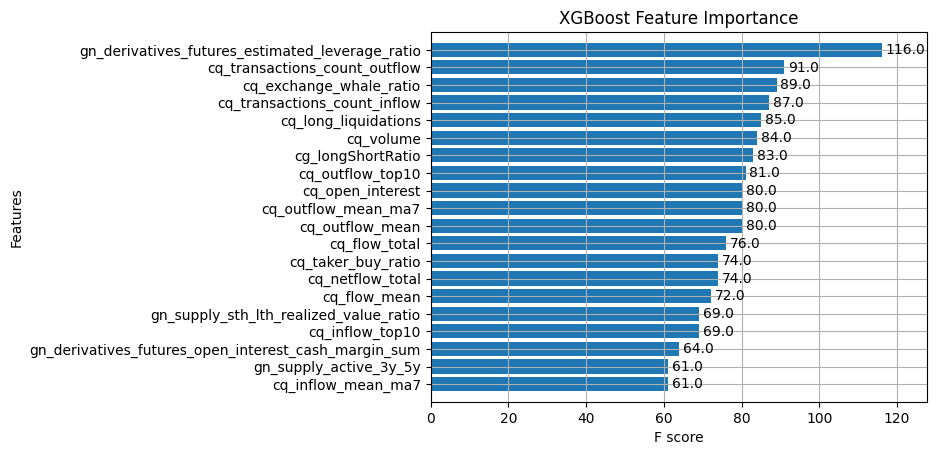

Index(['start_time', 'cg_longShortRatio', 'cg_longAccount', 'cg_buy',
       'cq_is_shutdown', 'cq_netflow_total', 'cq_transactions_count_inflow',
       'cq_transactions_count_outflow', 'cq_reserve', 'cq_reserve_usd',
       'cq_funding_rates', 'cq_flow_mean', 'cq_flow_total',
       'cq_exchange_whale_ratio', 'cq_outflow_mean', 'cq_outflow_mean_ma7',
       'cq_outflow_top10', 'cq_inflow_mean', 'cq_inflow_mean_ma7',
       'cq_inflow_top10'],
      dtype='object')


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Assuming df is your processed DataFrame and 'target' is the column you want to predict
X = df.drop(columns=['date', 'future_target', 'start_time', 'unified_close', 'return', 'unified_low', 'unified_high'])
y = df['future_target'].apply(lambda x: 1 if x != 0 else 0)  # Set 1 for any significant movement, 0 for no movement

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, importance_type='weight', max_num_features=20, height=0.8)
plt.title('XGBoost Feature Importance')
plt.show()


Assumption 2: Focus on features directly related to the whale ratio, assuming that large holders (whales) moving their coins to exchanges is a leading indicator of market behavior.


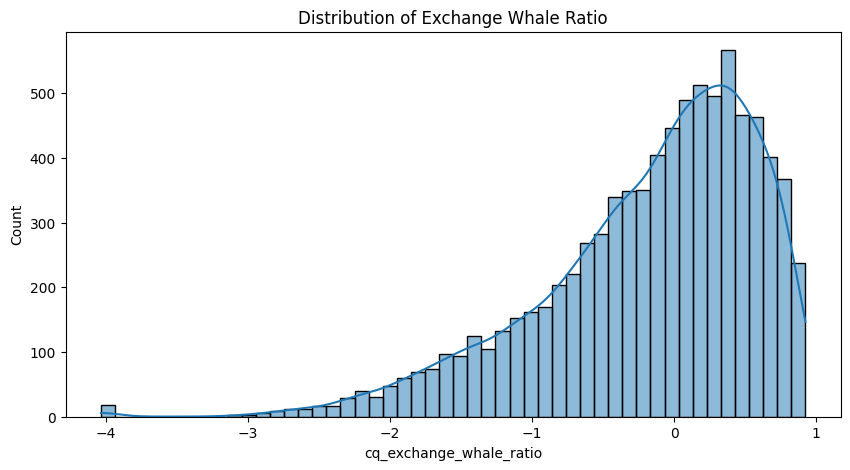

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df already loaded and processed
# Plot distribution
plt.figure(figsize=(10,5))
sns.histplot(df['cq_exchange_whale_ratio'], bins=50, kde=True)
plt.title('Distribution of Exchange Whale Ratio')
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:05:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


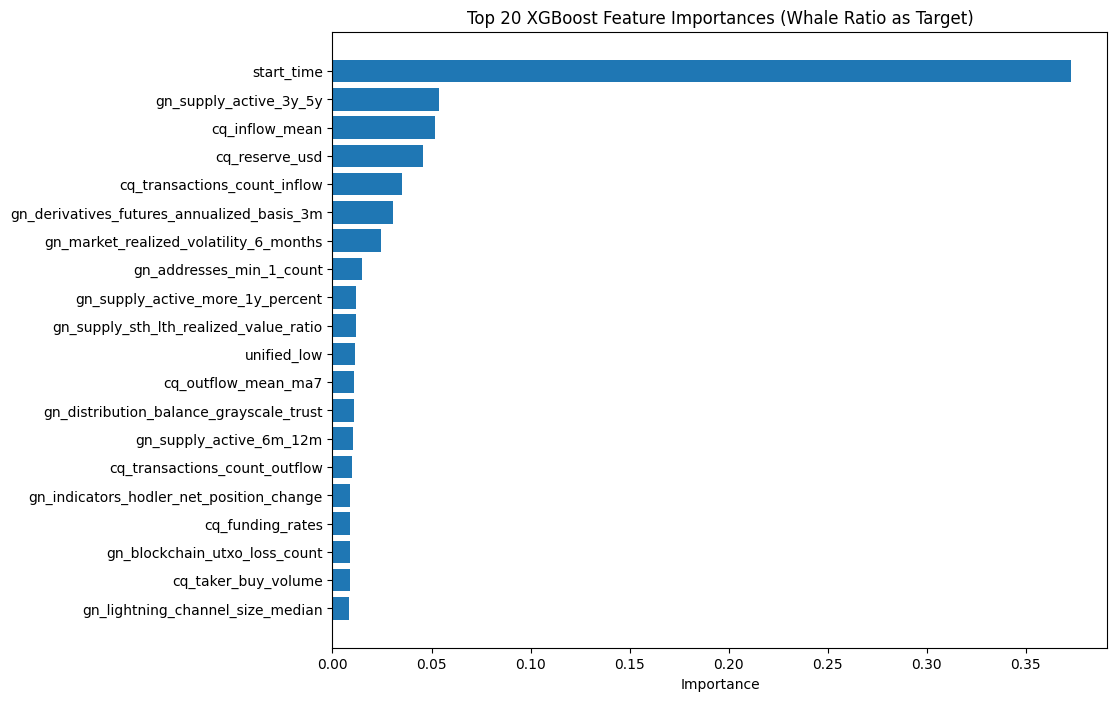

In [25]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('btc_features_output.csv')

# Create target: classify if whale ratio > 0.5
df['target'] = (df['cq_exchange_whale_ratio'] > 0.5).astype(int)

# Features
X = df.drop(columns=['date', 'cq_exchange_whale_ratio', 'target'])
y = df['target']

# Clean missing values
X = X.dropna()
y = y.loc[X.index]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Get feature importance
importances = model.feature_importances_
feature_names = X.columns

# Create DataFrame for sorting
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort by importance descending
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Optional: plot
plt.figure(figsize=(10,8))
plt.barh(importance_df['feature'].head(20)[::-1], importance_df['importance'].head(20)[::-1])
plt.xlabel("Importance")
plt.title("Top 20 XGBoost Feature Importances (Whale Ratio as Target)")
plt.show()

In [ ]:
import pandas as pd

df2 = pd.read_csv('top_20_features_with_target_and_start_time.csv')
df2.head()

# Show the first 5 rows
print(df2.head())

# Show the column names
print(df2.columns.tolist())

   target  future_avg_return  gn_market_realized_volatility_6_months  \
0       0           0.039015                                0.816415   
1       0           0.038236                                0.816296   
2       0          -0.062149                                0.816209   
3       0          -0.040840                                0.816098   
4       0          -0.098299                                0.815936   

   unified_close    start_time  cg_longAccount  \
0       0.167992  1.681603e+12       -0.772040   
1       0.165489  1.681607e+12       -0.756042   
2       0.168318  1.681610e+12       -0.764389   
3       0.174547  1.681614e+12       -0.764389   
4       0.171817  1.681618e+12       -0.772735   

   gn_mining_miners_unspent_supply  gn_lightning_channel_size_median  \
0                        -1.748454                          0.529342   
1                        -1.763118                          0.529342   
2                        -1.756535                